In [296]:
import torch
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
from matplotlib import rc
matplotlib.rcParams['figure.dpi'] = 150
f_path = "/System/Library/Fonts/Helvetica.ttc"
font_name = fm.FontProperties(fname=f_path).get_name()
rc('font', family=font_name, size=13)

import matplotlib.pyplot as plt
from sentence_transformers import models, SentenceTransformer
from collections import defaultdict
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from scipy.stats import binned_statistic

 * Goal 
  * visualize user embedding in the pc space
  * visualize clustering and separation of different user groups based on self reported survey data

## Load user embeddings

In [297]:
model_types = ['model_bert_ft', 'model_roberta-base_ft', 'model_bert', 'model_roberta-base']#, 'model_sbert_ft', 'model_sbert'
model_labels = ['BERT (Fine-tuned)', 'S-BERT (Fine-tuned)', 'BERT', 'S-BERT'] #, 'Finetuned SBERT roberta', 'SBERT roberta'

In [298]:
data_idx = 0

In [299]:
with open('../dataset/UserEmbeddings/user2embeddingvector_data(%d)_model(model_roberta-base_ft).p'%data_idx, 'rb') as f:
    user2embedding_ft = pickle.load(f)
    
with open('../dataset/UserEmbeddings/user2embeddingvector_data(%d)_model(model_roberta-base).p'%data_idx, 'rb') as f:
    user2embedding_base = pickle.load(f)    

In [300]:
len(user2embedding_ft), len(user2embedding_base)

(35447, 35447)

## Load user information

In [301]:
import json
with open('../dataset/01_rawdata/users.json','r') as f:
    userinfo = json.load(f)

## Finding PC space of original belief space

In [302]:
#load dictionary {beliefs: embedding vector}  
model2beleifemb = {}
for model_type in model_types:
    with open('../dataset/BeliefEmbeddingResults/BeliefEmbeddings_data(0)_model(%s).p'%(model_type), 'rb') as f:
        model2beleifemb[model_type] = pickle.load(f)

In [303]:
belief_keys_ft = list(model2beleifemb['model_roberta-base_ft'].keys())
belief_vectors_ft = list(model2beleifemb['model_roberta-base_ft'].values())        

belief_keys_base = list(model2beleifemb['model_roberta-base'].keys())
belief_vectors_base = list(model2beleifemb['model_roberta-base'].values())        

In [304]:
from sklearn.manifold import TSNE                   # final reduction
from sklearn.decomposition import PCA                   # final reduction

pca_ft = PCA(random_state=42)
pca_ft.fit(belief_vectors_ft)

pca_base = PCA(random_state=42)
pca_base.fit(belief_vectors_base)


PCA(random_state=42)

## Representing users in the same PC space

In [305]:
#2dim np.array two rows of usermat_ft and usermat_base represent the same user
usermat_ft = []
for user in user2embedding_ft:
    usermat_ft.append(user2embedding_ft[user])
usermat_ft = np.array(usermat_ft)

usermat_base = []
for user in user2embedding_base:
    usermat_base.append(user2embedding_base[user])
usermat_base = np.array(usermat_base)

(usermat_ft.shape, usermat_base.shape)

((35447, 768), (35447, 768))

In [306]:
#pca transform (get user representation in PC space)
user_pc_ft = pca_ft.transform(usermat_ft)
user_pc_base = pca_base.transform(usermat_base)

## User information 

### A. Political party

In [307]:
parties = np.zeros( len(user2embedding_ft) )

party_type = {'Democratic Party':1, 'Republican Party':2}

for idx, e in enumerate(user2embedding_ft):
    if e in userinfo and userinfo[e]['party'] in party_type:
        parties[idx] = party_type[userinfo[e]['party']]
            
parties = parties.astype(int)                

democratic_indices = []
republican_indices = []

for idx, e in enumerate(parties):
    if e == 1:
        democratic_indices.append(idx)
    elif e ==2:
        republican_indices.append(idx)
        
print(len(democratic_indices), len(republican_indices), len(democratic_indices)+len(republican_indices))
print("out of", len(user2embedding_ft))

1652 1683 3335
out of 35447


### ### B. Christian vs. Atheist

In [308]:
religion_info = np.zeros( len(user2embedding_ft) )

for idx, e in enumerate(user2embedding_ft):
    if e in userinfo:
        if 'Christian' in userinfo[e]['religious_ideology']:
            religion_info[idx] = 1
        elif  userinfo[e]['religious_ideology'] == 'Atheist':
            religion_info[idx] = 2
    
religion_info = religion_info.astype(int)                

In [309]:
christian_indices = []
atheist_indices = []

for idx, e in enumerate(religion_info):
    if e == 1:
        christian_indices.append(idx)
    elif e ==2:
        atheist_indices.append(idx)

print(len(christian_indices), len(atheist_indices), len(christian_indices)+len(atheist_indices))
print("out of", len(user2embedding_ft))

4906 2788 7694
out of 35447


In [310]:
category2groups = {} #category -> {group별 index list} dictionary 형태로 저장

category2groups['Political party'] = {'Republican': republican_indices, 'Democratic': democratic_indices}
category2groups['Religion'] = {'Christian': christian_indices, 'Atheist': atheist_indices}

category2groups['Religion'].keys()

dict_keys(['Christian', 'Atheist'])

### C. Other issues

In [311]:
big_issues = list(userinfo['000001']['big_issues_dict'].keys())
len(big_issues)

48

In [312]:
for issue in tqdm(big_issues):
    
    pro_indices = []
    con_indices = []

    for idx, e in enumerate(user2embedding_ft):

        if e in userinfo:

            if userinfo[e]['big_issues_dict'][issue] == 'Pro':
                pro_indices.append(idx)            

            elif userinfo[e]['big_issues_dict'][issue] == 'Con':
                con_indices.append(idx)
    
    category2groups[issue] = {'Pro':pro_indices, 'Con':con_indices} 

100%|███████████████████████████████████████████| 48/48 [00:01<00:00, 30.19it/s]


In [313]:
for issue in category2groups.keys():
    print(issue)
    for e in category2groups[issue]:
        print(e, len(category2groups[issue][e]))
    print()

Political party
Republican 1683
Democratic 1652

Religion
Christian 4906
Atheist 2788

Abortion
Pro 5138
Con 5046

Affirmative Action
Pro 1970
Con 3648

Animal Rights
Pro 4807
Con 1033

Barack Obama
Pro 2225
Con 2962

Border Fence
Pro 3713
Con 3459

Capitalism
Pro 3562
Con 1331

Civil Unions
Pro 4255
Con 1640

Death Penalty
Pro 4889
Con 4749

Drug Legalization
Pro 4683
Con 4388

Electoral College
Pro 1555
Con 2399

Environmental Protection
Pro 7037
Con 1007

Estate Tax
Pro 1782
Con 3042

European Union
Pro 1792
Con 1189

Euthanasia
Pro 3776
Con 1748

Federal Reserve
Pro 1117
Con 1289

Flat Tax
Pro 2093
Con 2637

Free Trade
Pro 3030
Con 682

Gay Marriage
Pro 6509
Con 2725

Global Warming Exists
Pro 6043
Con 2120

Globalization
Pro 2180
Con 1015

Gold Standard
Pro 1321
Con 1134

Gun Rights
Pro 5840
Con 2533

Homeschooling
Pro 3062
Con 1384

Internet Censorship
Pro 725
Con 4612

Iran-Iraq War
Pro 1174
Con 5183

Labor Union
Pro 3514
Con 1690

Legalized Prostitution
Pro 2599
Con 2209

Medic

In [314]:
idx2user = {}
user2idx = {}

for idx, e in enumerate(user2embedding_ft):
    idx2user[idx] = e
    user2idx[e] = idx

In [315]:
with open('../dataset/User_survey/idx2user.p','wb') as f:
    pickle.dump(idx2user, f)

with open('../dataset/User_survey/user2idx.p','wb') as f:
    pickle.dump(user2idx, f)
    
with open('../dataset/User_survey/issue2groups(useridx).p','wb') as f:
    pickle.dump(category2groups, f)    

## Visualization - SBERT-FT

### User history info - for scatter plot size 

In [316]:
with open('../dataset/04_K-fold_dataset/df_train_idx%d.p'%data_idx, 'rb') as f:
    df_train = pickle.load(f)
    
user2history = {}
for g, dat in df_train.groupby('username'):
    user2history[g] = len(dat)    

In [317]:
history_length = []
for e in user2embedding_ft:
    history_length.append(user2history[e])
history_length = np.array(history_length)    

### kde plot (political party)

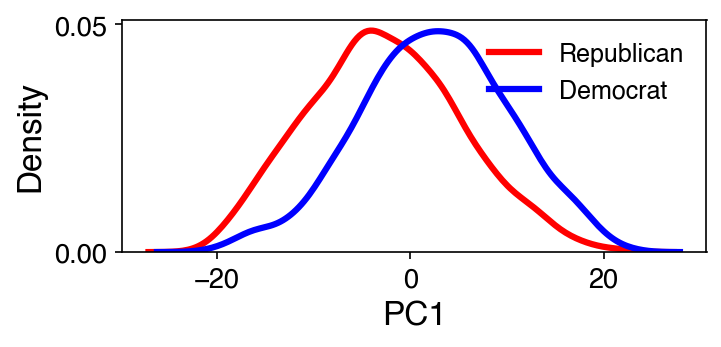

In [328]:
all_indices = category2groups['Political party']['Republican'] + category2groups['Political party']['Democratic']

xs = []
ys = []
sizes = []
colors = []
parties = []

node_size = 12*np.log(history_length)

np.random.shuffle(all_indices)

for e in all_indices:
    xs.append( user_pc_ft[e,0] )
    ys.append( user_pc_ft[e,1] )
    sizes.append( node_size[e] )
    
    if e in category2groups['Political party']['Democratic']:
        colors.append('b')
        parties.append('Democratic') 
    else:
        colors.append('r')
        parties.append('Republican') 
        

dat = pd.DataFrame({'x':xs, 'y':ys, 'size':sizes, 'party':parties})

plt.figure(figsize=(5,2.5))
plt.xticks([-20, 0, 20], fontsize=13)
plt.yticks([0, 0.05])

g = sns.kdeplot(data=dat[dat['party']=='Republican'], x='x', lw=3, color='r', label='Republican') 
g = sns.kdeplot(data=dat[dat['party']=='Democratic'], x='x', lw=3, color='b', label='Democrat') 

plt.legend(frameon=False, fontsize=12)



plt.xlabel('PC1', fontsize=16)
plt.ylabel('Density', fontsize=16)

plt.tight_layout()
plt.savefig('../fig/UserEmbeddingPC/political_party_histogram(roberta-base-ft).pdf',transparent=True, bbox_inches='tight')

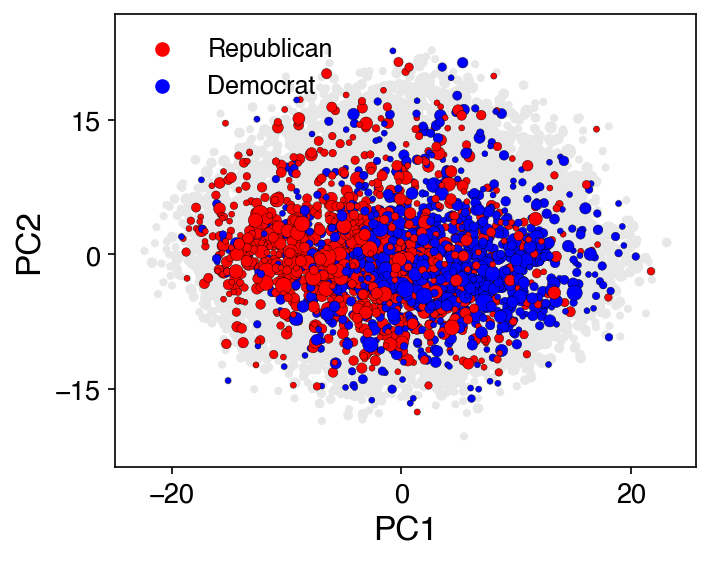

In [329]:
plt.figure(figsize=(5,4))
ax = plt.axes()

plt.scatter(user_pc_ft[:,0], user_pc_ft[:,1], marker='o', s=node_size, color='#E7E7E7')
plt.scatter(xs, ys, s=sizes, marker='o', alpha=1, color=colors, edgecolor='k', lw=0.2)

plt.scatter([],[], color='#E7E7E7')
plt.scatter([],[], color='r', label='Republican')
plt.scatter([],[], color='b', label='Democrat')

plt.xticks([-20, 0, 20],fontsize=13)
plt.yticks([-15, 0, +15],fontsize=13)

plt.xlabel('PC1', fontsize=16)
plt.ylabel('PC2', fontsize=16)
plt.legend(loc=2, fontsize=12, frameon=False)
plt.savefig('../fig/UserEmbeddingPC/political_party_scatter(roberta-base-ft).pdf',transparent=True, bbox_inches='tight')
plt.savefig('../fig/UserEmbeddingPC/political_party_scatter(roberta-base-ft).png', dpi=300, transparent=0, bbox_inches='tight')
plt.show()


### kde plot (Religion)

In [320]:
category2groups['Religion'].keys()

dict_keys(['Christian', 'Atheist'])

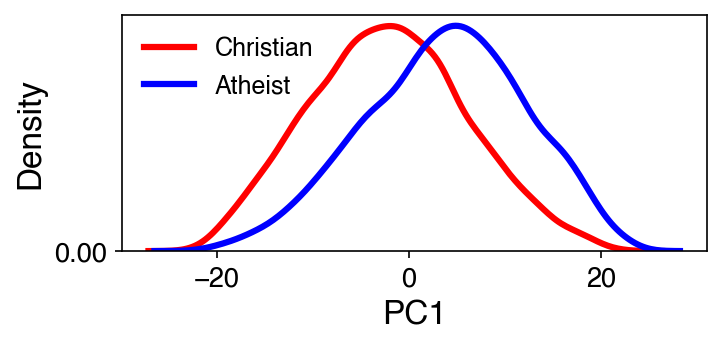

In [321]:
all_indices = category2groups['Religion']['Christian'] + category2groups['Religion']['Atheist']

xs = []
ys = []
sizes = []
colors = []
parties = []

node_size = 12*np.log(history_length)

np.random.shuffle(all_indices)

for e in all_indices:
    xs.append( user_pc_ft[e,0] )
    ys.append( user_pc_ft[e,1] )
    sizes.append( node_size[e] )
    
    if e in category2groups['Religion']['Christian']:
        colors.append('r')
        parties.append('Christian') 
    else:
        colors.append('b')
        parties.append('Atheist') 
        

dat = pd.DataFrame({'x':xs, 'y':ys, 'size':sizes, 'Religion':parties})

plt.figure(figsize=(5,2.5))
plt.xticks([-20, 0, 20], fontsize=13)
plt.yticks([0, 0.05])

g = sns.kdeplot(data=dat[dat['Religion']=='Christian'], x='x', lw=3, color='r', label='Christian') 
g = sns.kdeplot(data=dat[dat['Religion']=='Atheist'], x='x', lw=3, color='b', label='Atheist') 

plt.legend(frameon=False, fontsize=12)



plt.xlabel('PC1', fontsize=16)
plt.ylabel('Density', fontsize=16)

plt.tight_layout()
plt.savefig('../fig/UserEmbeddingPC/religion_histogram(roberta-base-ft).pdf',transparent=True, bbox_inches='tight')

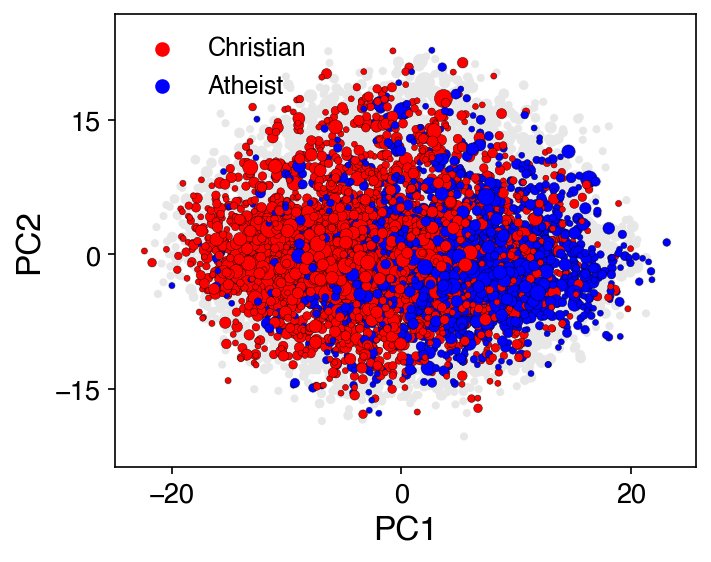

In [322]:
plt.figure(figsize=(5,4))
ax = plt.axes()

plt.scatter(user_pc_ft[:,0], user_pc_ft[:,1], marker='o', s=node_size, color='#E7E7E7')
plt.scatter(xs, ys, s=sizes, marker='o', alpha=1, color=colors, edgecolor='k', lw=0.2)

plt.scatter([],[], color='#E7E7E7')
plt.scatter([],[], color='r', label='Christian')
plt.scatter([],[], color='b', label='Atheist')

plt.xticks([-20, 0, 20],fontsize=13)
plt.yticks([-15, 0, +15],fontsize=13)

plt.xlabel('PC1', fontsize=16)
plt.ylabel('PC2', fontsize=16)
plt.legend(loc=2, fontsize=12, frameon=False)
#plt.savefig('../fig/UserEmbeddingPC/religion_scatter(roberta-base-ft).pdf',transparent=True, bbox_inches='tight')
plt.savefig('../fig/UserEmbeddingPC/religion_scatter(roberta-base-ft).png',transparent=0, dpi=300, bbox_inches='tight')
plt.show()


## Visualization - Base-SBERT model

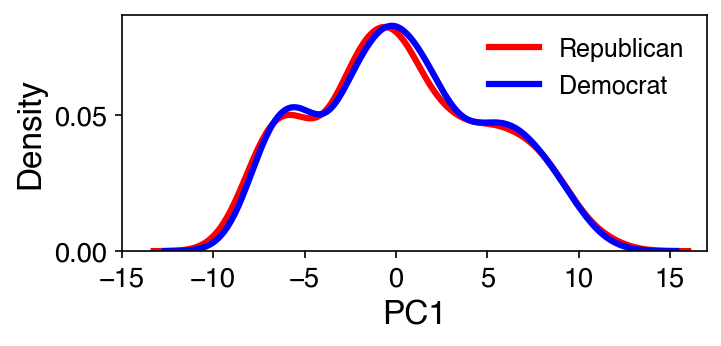

In [323]:
all_indices = category2groups['Political party']['Republican'] + category2groups['Political party']['Democratic']

xs = []
ys = []
sizes = []
colors = []
parties = []

node_size = 12*np.log(history_length)

np.random.shuffle(all_indices)

for e in all_indices:
    xs.append( user_pc_base[e,0] )
    ys.append( user_pc_base[e,1] )
    sizes.append( node_size[e] )
    
    if e in category2groups['Political party']['Democratic']:
        colors.append('b')
        parties.append('Democratic') 
    else:
        colors.append('r')
        parties.append('Republican') 
        

dat = pd.DataFrame({'x':xs, 'y':ys, 'size':sizes, 'party':parties})

plt.figure(figsize=(5,2.5))
plt.xticks(fontsize=13)
plt.yticks([0, 0.05])
plt.xlim(-15,17)
g = sns.kdeplot(data=dat[dat['party']=='Republican'], x='x', lw=3, color='r', label='Republican') 
g = sns.kdeplot(data=dat[dat['party']=='Democratic'], x='x', lw=3, color='b', label='Democrat') 

plt.legend(frameon=False, fontsize=12)



plt.xlabel('PC1', fontsize=16)
plt.ylabel('Density', fontsize=16)

plt.tight_layout()
plt.savefig('../fig/UserEmbeddingPC/political_party_histogram(base).pdf',transparent=True, bbox_inches='tight')

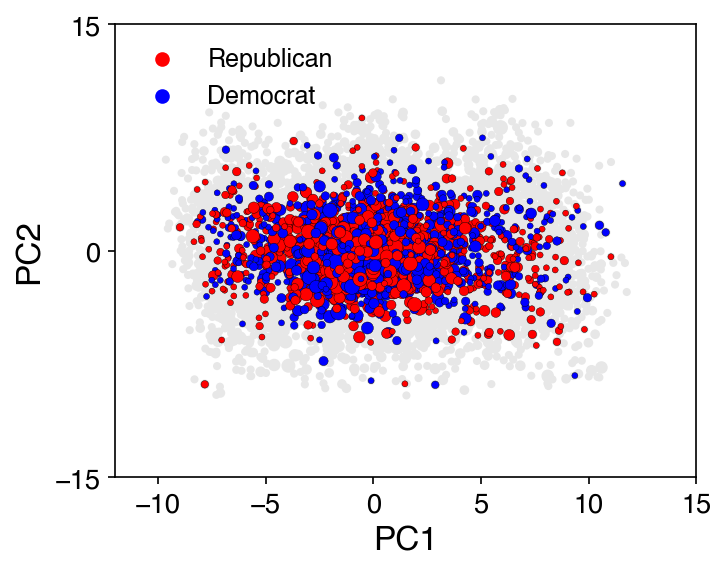

In [324]:
plt.figure(figsize=(5,4))
ax = plt.axes()

plt.scatter(user_pc_base[:,0], user_pc_base[:,1], marker='o', s=node_size, color='#E7E7E7')
plt.scatter(xs, ys, s=sizes, marker='o', alpha=1, color=colors, edgecolor='k', lw=0.2)

plt.scatter([],[], color='#E7E7E7')
plt.scatter([],[], color='r', label='Republican')
plt.scatter([],[], color='b', label='Democrat')

plt.xticks(fontsize=13)
plt.yticks([-15, 0, +15],fontsize=13)
plt.xlim(-12,15)
plt.xlabel('PC1', fontsize=16)
plt.ylabel('PC2', fontsize=16)
plt.legend(loc=2, fontsize=12, frameon=False)
#plt.savefig('../fig/UserEmbeddingPC/political_party_scatter(base).pdf',transparent=True, bbox_inches='tight')
plt.savefig('../fig/UserEmbeddingPC/political_party_scatter(base).png',transparent=0,dpi=300, bbox_inches='tight')
plt.show()


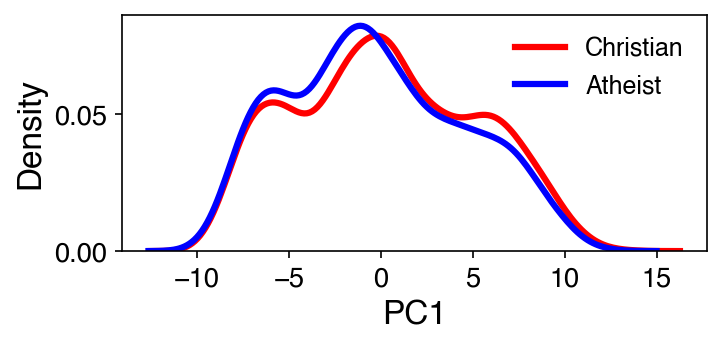

In [325]:
all_indices = category2groups['Religion']['Christian'] + category2groups['Religion']['Atheist']

xs = []
ys = []
sizes = []
colors = []
parties = []

node_size = 12*np.log(history_length)

np.random.shuffle(all_indices)

for e in all_indices:
    xs.append( user_pc_base[e,0] )
    ys.append( user_pc_base[e,1] )
    sizes.append( node_size[e] )
    
    if e in category2groups['Religion']['Christian']:
        colors.append('r')
        parties.append('Christian') 
    else:
        colors.append('b')
        parties.append('Atheist') 
        

dat = pd.DataFrame({'x':xs, 'y':ys, 'size':sizes, 'Religion':parties})

plt.figure(figsize=(5,2.5))
plt.xticks(fontsize=13)
plt.yticks([0, 0.05])

g = sns.kdeplot(data=dat[dat['Religion']=='Christian'], x='x', lw=3, color='r', label='Christian') 
g = sns.kdeplot(data=dat[dat['Religion']=='Atheist'], x='x', lw=3, color='b', label='Atheist') 

plt.legend(frameon=False, fontsize=12)



plt.xlabel('PC1', fontsize=16)
plt.ylabel('Density', fontsize=16)

plt.tight_layout()
plt.savefig('../fig/UserEmbeddingPC/religion_histogram(base).pdf',transparent=True, bbox_inches='tight')

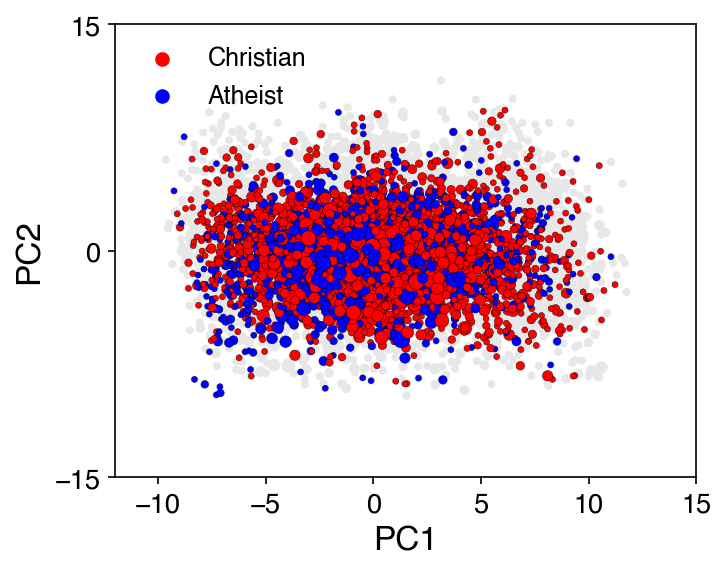

In [326]:
plt.figure(figsize=(5,4))
ax = plt.axes()

plt.scatter(user_pc_base[:,0], user_pc_base[:,1], marker='o', s=node_size, color='#E7E7E7')
plt.scatter(xs, ys, s=sizes, marker='o', alpha=1, color=colors, edgecolor='k', lw=0.2)

plt.scatter([],[], color='#E7E7E7')
plt.scatter([],[], color='r', label='Christian')
plt.scatter([],[], color='b', label='Atheist')

plt.xticks(fontsize=13)
plt.yticks([-15, 0, +15],fontsize=13)

plt.xlabel('PC1', fontsize=16)
plt.ylabel('PC2', fontsize=16)
plt.xlim(-12,15)
plt.legend(loc=2, fontsize=12, frameon=False)
plt.savefig('../fig/UserEmbeddingPC/religion_scatter(base).pdf',transparent=True, bbox_inches='tight')
plt.savefig('../fig/UserEmbeddingPC/religion_scatter(base).png',transparent=0, dpi=300, bbox_inches='tight')
plt.show()


## Big issue visualization 

In [327]:
category2groups.keys()

dict_keys(['Political party', 'Religion', 'Abortion', 'Affirmative Action', 'Animal Rights', 'Barack Obama', 'Border Fence', 'Capitalism', 'Civil Unions', 'Death Penalty', 'Drug Legalization', 'Electoral College', 'Environmental Protection', 'Estate Tax', 'European Union', 'Euthanasia', 'Federal Reserve', 'Flat Tax', 'Free Trade', 'Gay Marriage', 'Global Warming Exists', 'Globalization', 'Gold Standard', 'Gun Rights', 'Homeschooling', 'Internet Censorship', 'Iran-Iraq War', 'Labor Union', 'Legalized Prostitution', 'Medicaid & Medicare', 'Medical Marijuana', 'Military Intervention', 'Minimum Wage', 'National Health Care', 'National Retail Sales Tax', 'Occupy Movement', 'Progressive Tax', 'Racial Profiling', 'Redistribution', 'Smoking Ban', 'Social Programs', 'Social Security', 'Socialism', 'Stimulus Spending', 'Term Limits', 'Torture', 'United Nations', 'War in Afghanistan', 'War on Terror', 'Welfare'])

In [336]:
def visualize_issue(issue, ax,  color1='orange', color2='#4D6EAC', finetuned=True): 
    
    all_indices = category2groups[issue]['Pro'] + category2groups[issue]['Con']
    xs = []
    ys = []
    sizes = []
    colors = []
    parties = []

    node_size = 12*np.log(history_length)

    np.random.shuffle(all_indices)

    if finetuned:
        user_pc = user_pc_ft
    else:
        user_pc = user_pc_base
    
    for e in all_indices:

        xs.append( user_pc[e,0] )
        ys.append( user_pc[e,1] )            
        sizes.append( node_size[e] )

        if e in category2groups[issue]['Pro']:
            colors.append(color2)
            parties.append('Pro') 
        else:
            colors.append(color1)
            parties.append('Con') 


    dat = pd.DataFrame({'x':xs, 'y':ys, 'size':sizes, 'party':parties})

    ax.scatter(user_pc[:,0], user_pc[:,1], marker='o', s=node_size, color='#E7E7E7')
    ax.scatter(xs, ys, s=sizes, marker='o', alpha=1, color=colors, edgecolor='k', lw=0.15)

    ax.scatter([],[], color='#E7E7E7')
    ax.scatter([],[], color=color2, label='Pro')
    ax.scatter([],[], color=color1, label='Con')

    ax.set_xlabel('PC1', fontsize=16)
    ax.set_ylabel('PC2', fontsize=16)
    ax.legend(loc=2, fontsize=12, frameon=False)

In [337]:
len(category2groups['Gay Marriage']['Pro']), len(category2groups['Gay Marriage']['Con']), 

(6509, 2725)

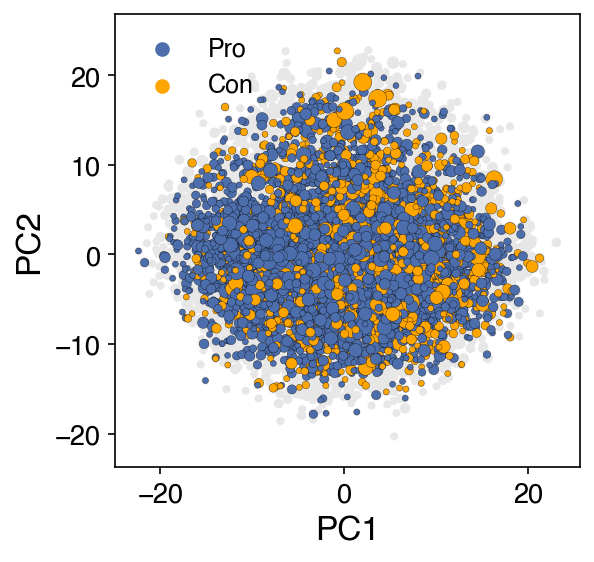

In [345]:
fig, ax = plt.subplots(figsize=(4,4))
visualize_issue('Gun Rights', ax=ax )

In [346]:
top_issues = [
"Gay Marriage",
"Abortion",
"Euthanasia",
"Global Warming Exists",
"National Health Care",
"Legalized Prostitution",
"Progressive Tax",
"Drug Legalization",
"Socialism",
"Border Fence",
"Smoking Ban",
"Affirmative Action"]

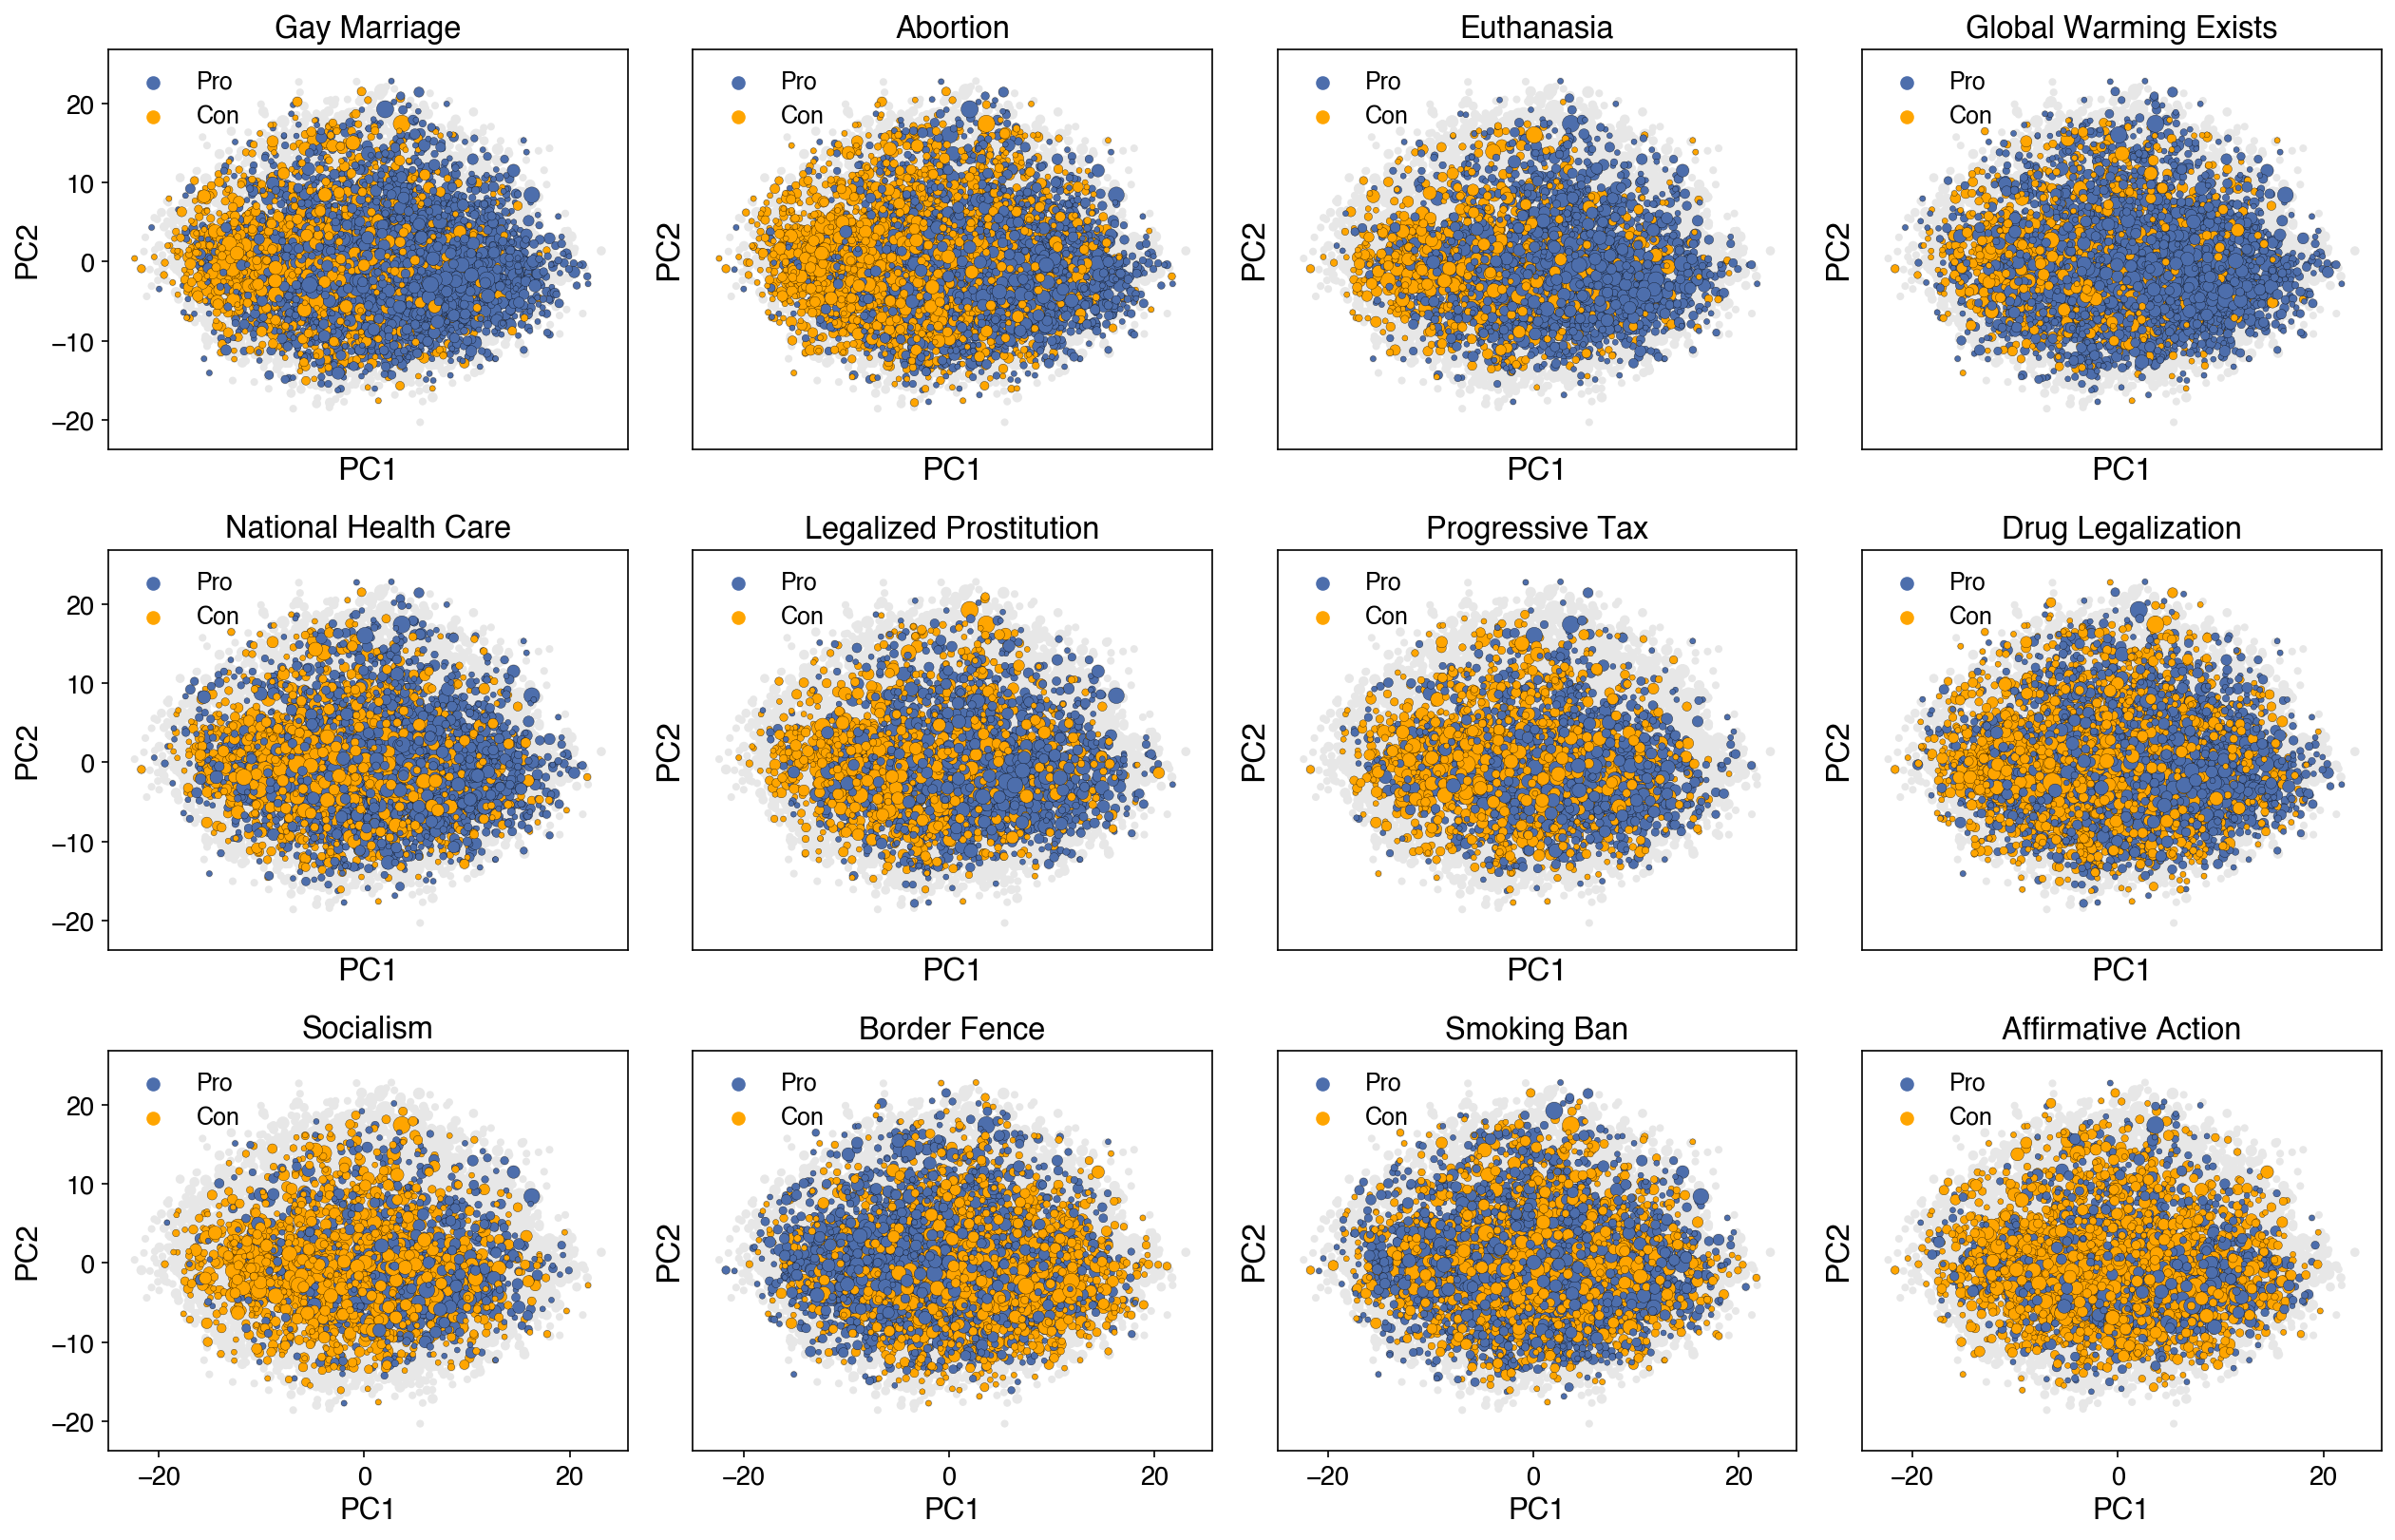

In [347]:
fig = plt.figure(figsize=(17,11))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for idx, issue in enumerate(top_issues):
    ax = fig.add_subplot(3, 4, idx+1)
    visualize_issue(issue, ax)
    ax.set_title(issue)
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    if idx//4==2:
        ax.set_xticks([-20,0,20])
        ax.set_xlabel('PC1', fontsize=15)
    if idx%4==0:
        ax.set_yticks([-20,-10,0,10,20])
        ax.set_ylabel('PC2', fontsize=15)

        
plt.tight_layout()
#plt.savefig('../fig/UserEmbeddingPC/BigIssues_PCA_SBERT-ft.pdf', transparent=True, bbox_inches='tight')    
plt.savefig('../fig/UserEmbeddingPC/BigIssues_PCA_SBERT-ft.png', dpi=200, transparent=0, bbox_inches='tight')    
plt.show()

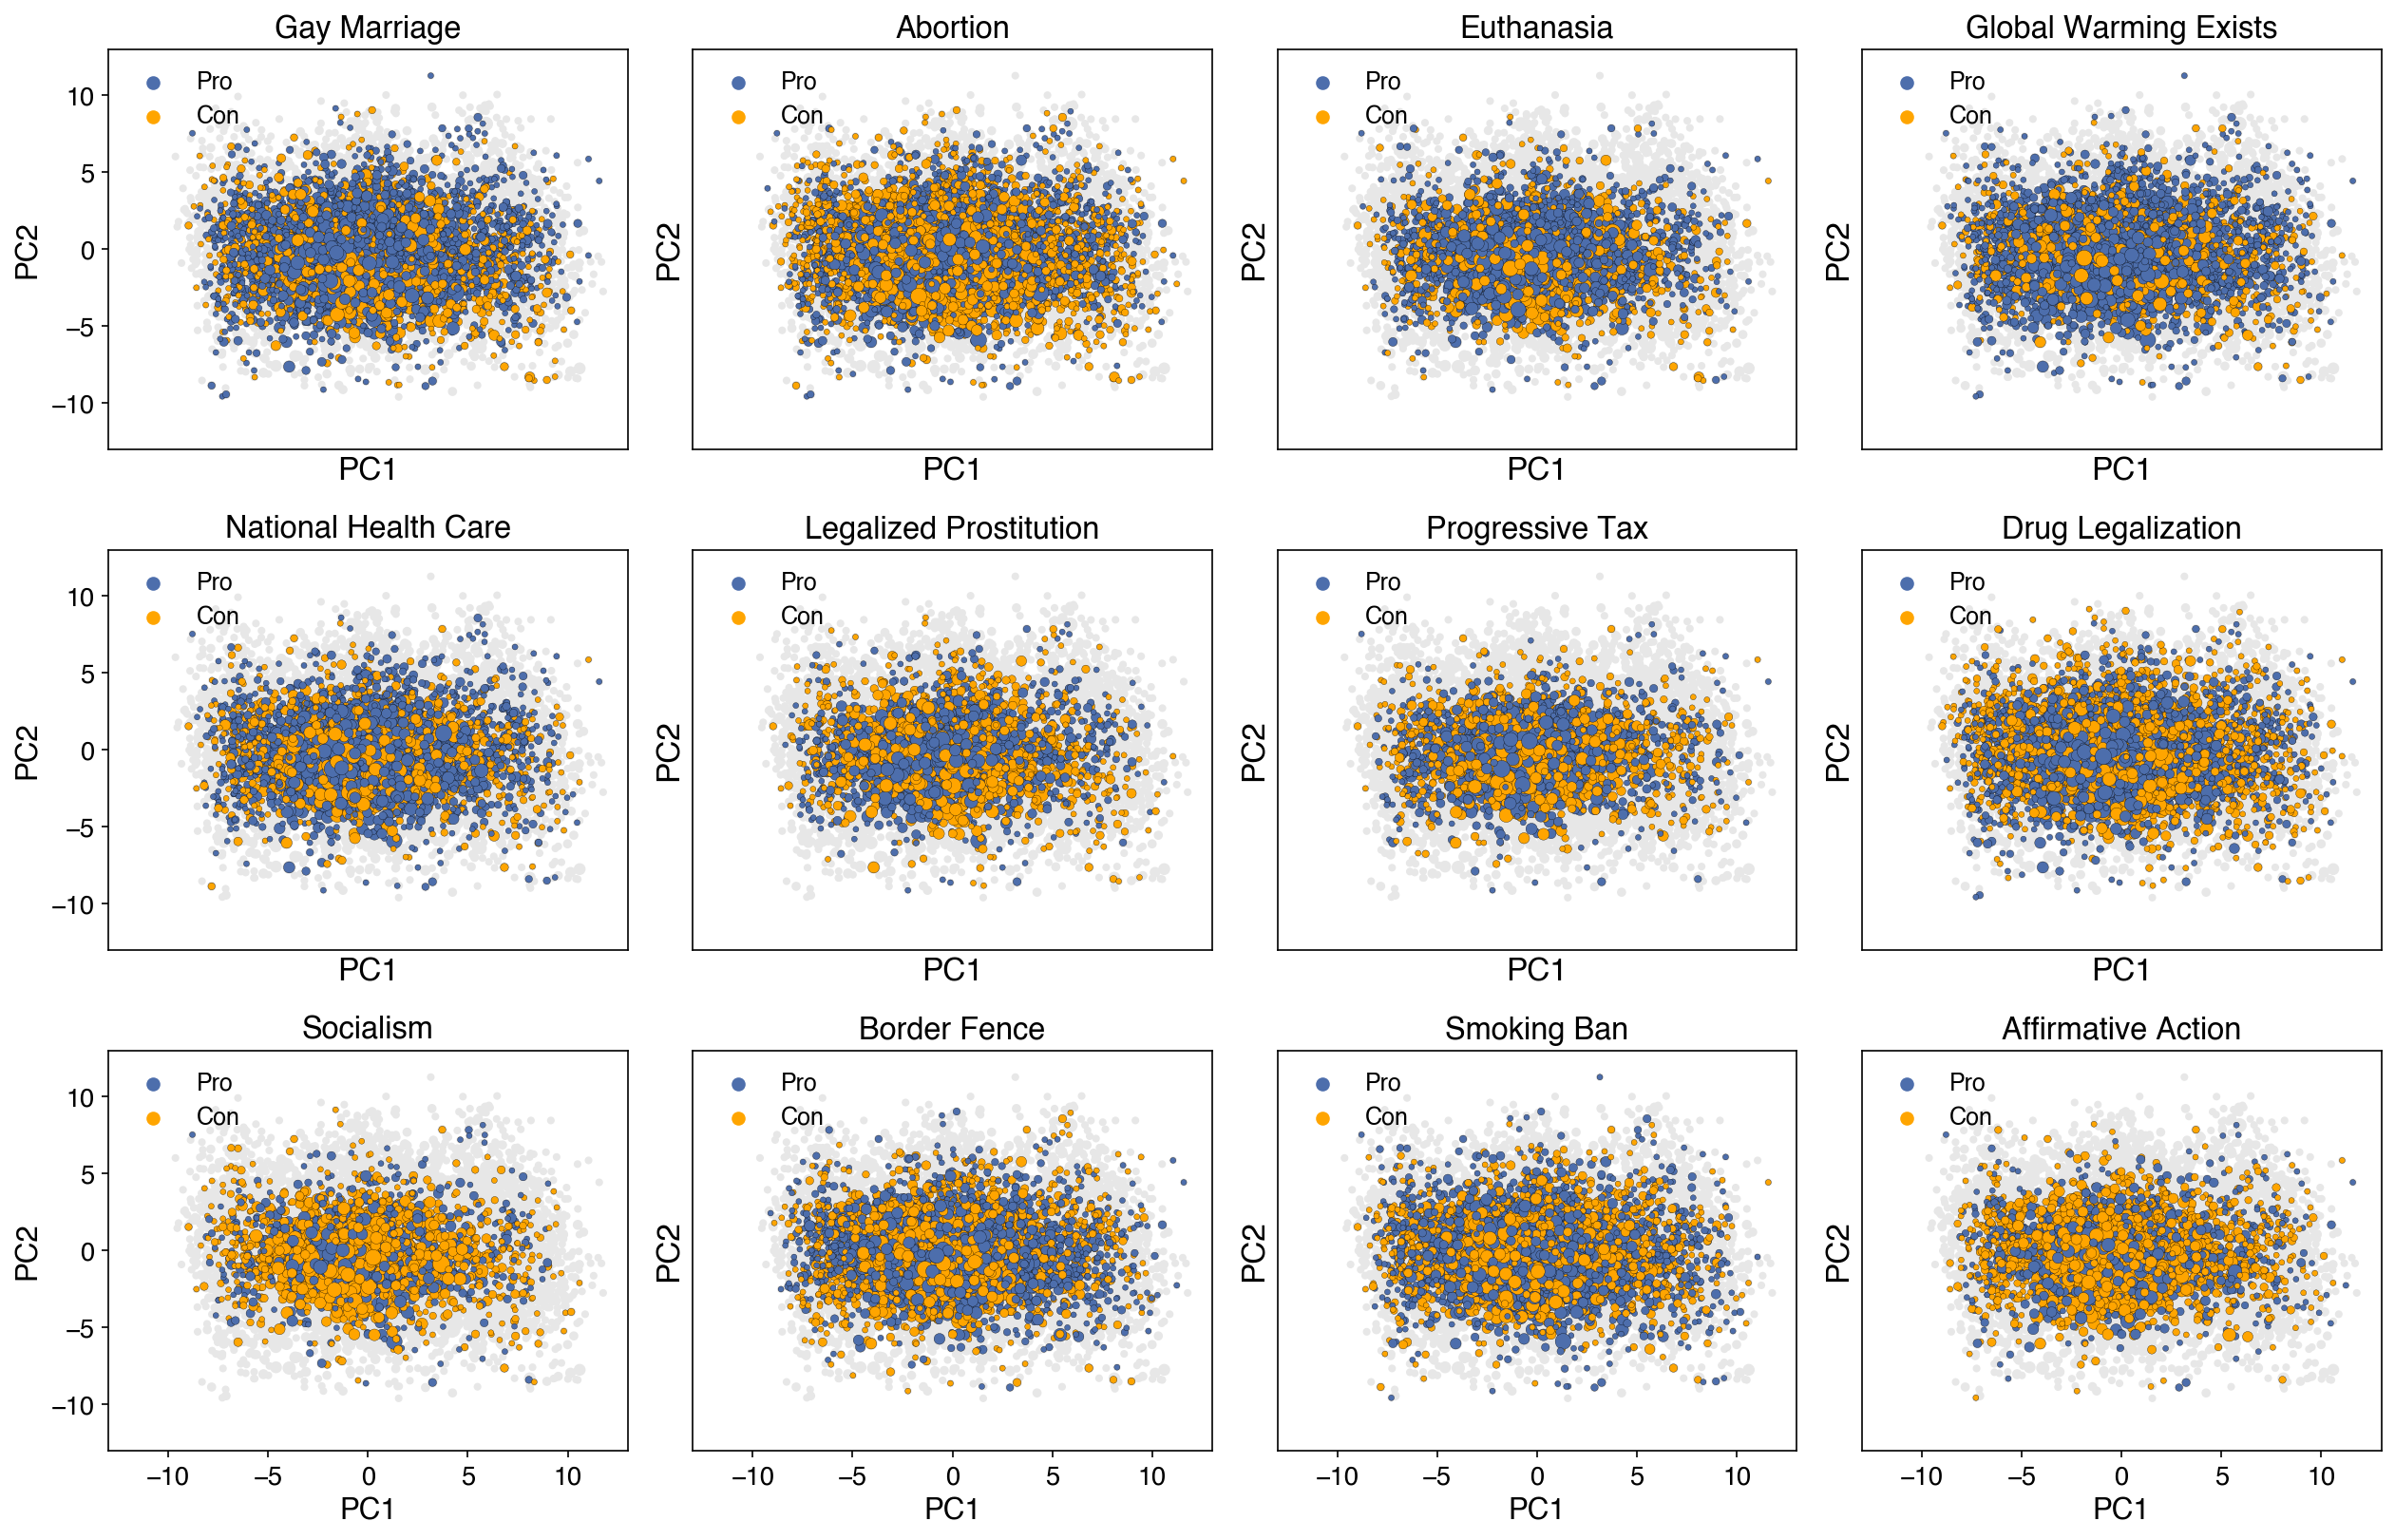

In [348]:
fig = plt.figure(figsize=(17,11))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for idx, issue in enumerate(top_issues):
    ax = fig.add_subplot(3, 4, idx+1)
    visualize_issue(issue, ax, finetuned=False)
    ax.set_title(issue)
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_xlim(-13,13)
    ax.set_ylim(-13,13)
    
    if idx//4==2:
        ax.set_xticks([-10,-5,0,5,10])        
        ax.set_xlabel('PC1', fontsize=15)
    if idx%4==0:
        ax.set_yticks([-10,-5,0,5,10]) 
        ax.set_ylabel('PC2', fontsize=15)

        
plt.tight_layout()
#plt.savefig('../fig/UserEmbeddingPC/BigIssues_PCA_SBERT-base.pdf', transparent=True, bbox_inches='tight')    
plt.savefig('../fig/UserEmbeddingPC/BigIssues_PCA_SBERT-base.png', dpi=200, transparent=0, bbox_inches='tight')    
plt.show()